# Training your first collective variable

Here we will give a brief overview of the process of training a data-driven collective variable with `mlcolvar`. As example we will perform a simple regression task for a particle in a 2D toy model potential named Muller-Brown.

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

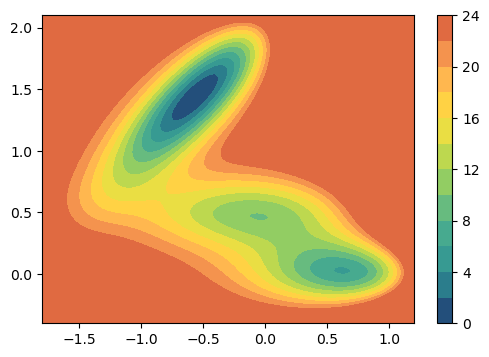

In [2]:
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D

plot_isolines_2D(muller_brown_potential,levels=12,max_value=24)

### Outline

Typically, the process of constructing a data-driven CV requires the following ingredients:
1) a **dataset** (with input features and possibly targets or labels)
2) a **model** (e.g. a neural network) and an objective function. 

Once we have them, we can combine them and optimize the CV (via a **trainer** object). 

Finally, we can export the CV in order to be deployed in PLUMED.

### Load files

We will load a COLVAR file produced by PLUMED which contains:
- the descriptors (features) which will be used as input of our model, in this case x and y coordinates of the particle
- the quantity to be reproduced (target) which in this case is the potential energy

To do this we can use the `load_dataframe` function contained in the `mlcolvar.utils.io` module.

In [5]:
from mlcolvar.utils.io import load_dataframe

filename = "data/muller-brown/unbiased/high-temp/COLVAR" 
df = load_dataframe(filename)
df.head()

,time,p.x,p.y,p.z,ene,pot.bias,pot.ene_bias,lwall.bias,lwall.force2,uwall.bias,uwall.force2
0,0.0,0.500000,0.000000,0.0,6.580981,6.580981,6.580981,0.0,0.0,0.0,0.0
1,1.0,0.285803,0.351447,0.0,11.506740,11.506740,11.506740,0.0,0.0,0.0,0.0
2,2.0,-0.004293,0.590710,0.0,11.821637,11.821637,11.821637,0.0,0.0,0.0,0.0
3,3.0,-0.530208,0.714688,0.0,16.812886,16.812886,16.812886,0.0,0.0,0.0,0.0
4,4.0,-1.015236,0.978306,0.0,8.821514,8.821514,8.821514,0.0,0.0,0.0,0.0


### Create dataset

We can now create the dataset which will be used to optimize the CV. To do this we can use the `DictionaryDataset` implemented in the `mlcolvar.data` module. In case of supervised regression task the keys should be 'data' and 'target'.

In [6]:
from mlcolvar.data import DictionaryDataset
from torch import Tensor

# define input and target features
X = df.filter(regex='p.x|p.y').values     #x,y coordinates
y = df[['ene']].values                    #target energy

# create dataset specifying a dictionary
dataset = DictionaryDataset(dict(data=Tensor(X),target=Tensor(y)))
dataset

DictionaryDataset( "data": [5001, 2], "target": [5001, 1] )

In order to avoid overfitting (i.e. learning to reproduce the training dataset but without the ability to generalize to similar data), it is always good to split the training data into training and validation. 

Here we use the `lightning` framework which takes care of these aspects through an object called `DataModule`. This takes a dataset and creates training, validation (and optionally also testing) dataloaders which are used by pytorch in the training loop. They are responsible also for dividing the data in batches, shuffling the data and so on, but all of this happens under the hood. We implemented a `DictionaryDataModule` which takes as input the dataset which we created above, as well as an indication on how to split data in train and validation sets (here we use 80/20% ratio.)

In [7]:
from mlcolvar.data import DictionaryDataModule

datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2],batch_size=1024)
datamodule

DictionaryDataModule(dataset -> DictionaryDataset( "data": [5001, 2], "target": [5001, 1] ),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=1024, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=1024, shuffle=True))

### Define the model

Having organized the data we can now the define the model that we are going to optimize in order to accomplish our regression task. The cvs are implemented in the `mlcolvar.cvs` module. In particular we are going to use a `RegressionCV`, which is implemented as a pytorch lightning module. It is composed by two blocks which are executed one after the other: 'norm_in' and 'nn'. The first is a normalization layer which standardize the data based on statistics on the training set, the second the actual FeedForward neural network. These blocks can be customized by passing a dictionary of keyword arguments as described below.

Here we will use a feedforward neural network with three layers and [25,50,25] nodes per layer.

In [8]:
from mlcolvar.cvs import RegressionCV

# specify number of nodes per layer (including input and output dimensions) 
layers = [X.shape[1],25,50,25,1]

# specify options for the nn block
nn_args = {'activation': 'relu'}
# specify options for the normalization layer (can be disabled by setting the norm args equal to None or False)
norm_args = {}

model = RegressionCV (layers, options={'norm_in':norm_args , 'nn': nn_args} )
model

RegressionCV(
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=25, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=25, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=50, out_features=25, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=25, out_features=1, bias=True)
    )
  )
)

The loss function is embedded inside the CV object, for a `RegressionCV` the default is the Mean Square Error (MSE), you will see how to customize it in the following tutorials.

### Define the trainer

The last ingredient that we need to define is a lightning `Trainer`, which ties together the module and the datamodule and performs the training/validation loop. This can be customized with all Lightning features, from logging the metrics to TensorBoard or using EarlyStopping or Learning Rate schedulers. In addition, it can be used to specify the devices to be used for training the CVs, without any extra modification to the code.

In this simple example we will only use a `MetricsCallback` to save the metrics into a dictionary as well as `EarlyStopping` criterion acting on the "valid_loss" (it will automatically stop the training after the validation loss does not increase for `patience` epochs.)

In [127]:
from lightning import Trainer
from lightning.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", patience=10, min_delta=1e-5)

# define trainer
trainer = Trainer(callbacks=[metrics, early_stopping],
                     logger=None, enable_checkpointing=False) #disable logger and checkpointing in this tutorial

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Optimize it!

Finally we can call the fit method of the trainer and optimize our model!

In [128]:
trainer.fit( model, datamodule )

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name   | Type          | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn     | FeedForward   | 2.7 K  | [2]      | [1]      
----------------------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 471: 100%|██████████| 4/4 [00:00<00:00, 46.14it/s, v_num=8] 


The train/valid losses are saved into the metrics object. We can use an helper function to plot them:

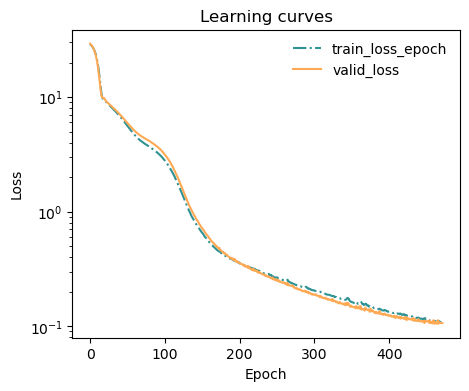

In [129]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='log')

### Analyze the results

Once the model is optimized, we can directly use it to predict the cv for new data. And of course, we can compare the predicted vs reference data.

Text(0, 0.5, 'Prediction')

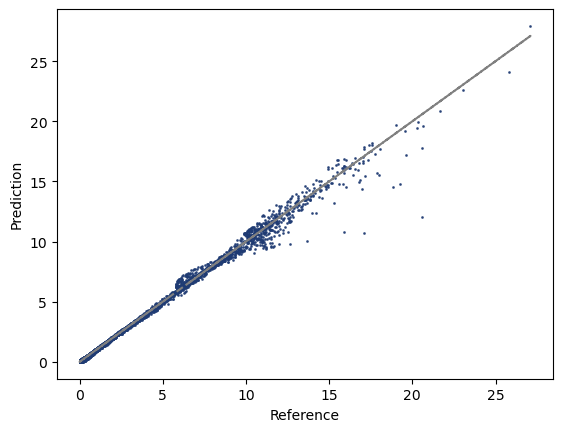

In [130]:
from torch import no_grad # allows for inference without gradients

# predict data
model.eval()
with no_grad():
    y_pred = model(Tensor(X))

# compare with reference
import matplotlib.pyplot as plt
_,ax = plt.subplots(dpi=100)
ax.scatter(y,y_pred,s=1,color='fessa0',alpha=0.8)
ax.plot(y,y,linestyle='--',color='grey')
#ax.set_xlim(-0.1,1.1)
#ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Reference')
ax.set_ylabel('Prediction')


Since this is a two-dimensional model potential we can also compare the results in the (x,y) space. To do that we need to compute the isolines of the CV and compare with the true potential. The prediction is actually rather accurate, except for the regions where few if any data points are available. 

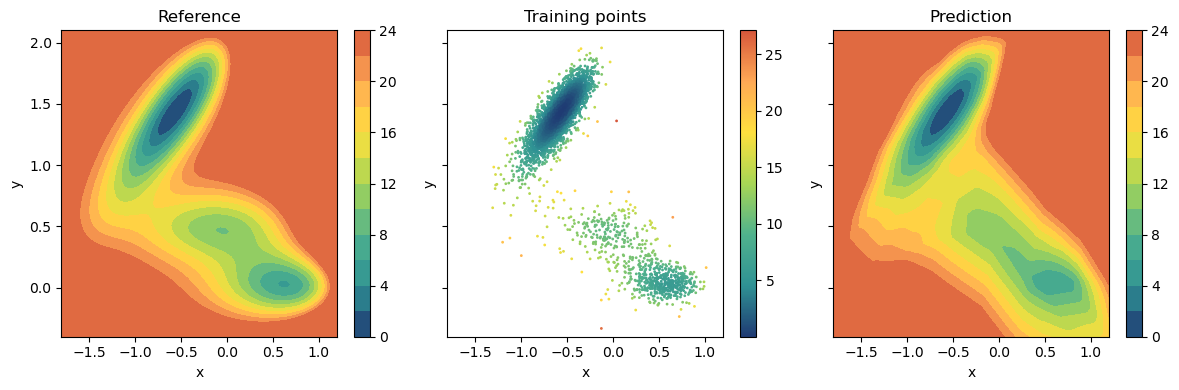

In [131]:
fig,axs = plt.subplots(1,3,dpi=100,figsize=(12,4),sharex=True,sharey=True)
for ax,title in zip(axs,['Reference','Training points','Prediction']):
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plot_isolines_2D(muller_brown_potential,levels=12,max_value=24,ax=axs[0])
pp = axs[1].scatter(X[:,0],X[:,1],c=y[:,0],s=1,alpha=1,cmap='fessa')
plt.colorbar(pp,ax=axs[1])
plot_isolines_2D(model,levels=12,max_value=24,ax=axs[2])
plt.tight_layout()

### Deploy the model in PLUMED

In order to deploy the model to PLUMED we first need to compile it TorchScript (see `torch.jit`). We will trace the model, meaning that all of the instructions that are executed in an example workflow will be compiled in a python-independent format. Once again we can use lightning wrapper to do so, and just call the method `to_torchscript`.

Then an example input file to evaluate and print the CV from PLUMED could be:

    # ------------- plumed.dat -------------
    p:  POSITION ATOM=1
    cv: PYTORCH_MODEl=model.ptc ARG=p.x,p.y
    
    PRINT STRIDE=100 ARG=cv.*
    # --------------------------------------

You made it to the end! This first tutorial was designed to give an overview on the process of training data-driven CVs with `mlcolvar`. You can now navigate through the CV-specific tutorials which describe the  different approaches which are implemented as well as information on how to customize the CVs and the training. 

## `mlcolvar` workflow
The main goal of `mlcolvar` is to make the construction of mlcolvar as straightforward and accessible as possible for all types of users.

In the basic workflow consists of few steps which corresponds to very few lines of code:
- Import training data using the functions in `utils`, i.e. PLUMED colvar files or others
- Organize the training data into a `DataModule` using the functions in `data`. This allows to expolit best the Lightning features
- Initialize the model as one of the CV classes in `cvs`.  
- Initialize a `lightning.trainer`, this takes care of training, validating, logs and boring stuff :)
- Export the trained model with `model.to_torchscript()`
- TODO Generate a PLUMED input file 
- Enjoy the CV in PLUMED with our awesome interface

## Structure of CVs classes in `mlcolvar`

The final product of `mlcolvar` library are of course the CVs.
These are defined as classes which inherit from from a `BaseCV` class and from `lightning.module`, which inherits from `torch.nn.module`.
The first super class is meant to define a template for all the CVs along with common utility methods and the handling of pre and post processing in the model. 

The second allows to exploit all the utilites from pytorch lightning.  

Each CV is characterized by its specific methods, attributes and properties, which are implemented on top of these two super classes.
The structure of CVs in `mlcolvar` is thought to be modular, indeed the core of each model is defined as a series of `BLOCKS`, implemented as `torch.nn.module`, that are automatically executed sequentially in a similar fashion to what is done with `torch.nn.sequential`.
Each CV then has a `loss_fn` attribute that sets the loss function which has to be minimized for the optimization of the trainable blocks.

The CV




## Structure of the code

### core
Implements building blocks of the mlcolvar classes
- **loss** :      Implements loss functions for the training of mlcolvar
- **nn** :        Implements trainable machine-learning building blocks of the mlcolvar classes, conceptually similar to torch.nn 
- **stats** :     Implements statistics-based builidng blocks for the mlcolvar classes
- **transform** : Implements non-trainable transformations of data

### cvs
Implements ready-to-use mlcolvar classes and the `BaseCV` template class.
The CVs are divided based on the criterion used for the optimization in: 
- **unsupervised** :      Only require data about the system (`Autoencoder_CV`and `VariationalAutoEncoderCV`, variational autoencoder CV).
- **supervised**:         Require either labeled data from the different metastable states of the system (`DeepLDA` and `DeepTDA`) or data and target to be matched (`RegressionCV`)
- **timelagged**:         Require time-lagged data from reactive trajectory (`DeepTICA`)

